# Modeling after Data Segmentation

### Loading

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
sys.path.append(r'C:\Frank\UoT 2024-2025\MIE8888 Project\M18\RUIWU') 
from helper_functions import * # Import Ruiwu's helper functions for data cleaning, slicing and aggregating

full_dataset = r"C:\Frank\UoT 2024-2025\MIE8888 Project\full_dataset_2.11.csv"
v1_data = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M19\df_v1.csv"
v2_data = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M19\df_v2.csv"
df = pd.read_csv(full_dataset, encoding="Windows-1252")
df_v1 = pd.read_csv(v1_data, encoding="Windows-1252")
df_v2 = pd.read_csv(v2_data, encoding="Windows-1252")

C:\Users\frank\AppData\Local\Temp\ipykernel_24832\3559286954.py:11: DtypeWarning: Columns (1,4,10,16,52,85,86,91) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(full_dataset, encoding="Windows-1252")


### Using V1 data for models 
V1 (Very Consistent): Max gap between visits is less than 2 years (Doesn’t matter how long the total history is, as long as it's consistent)

In [68]:
df_v1.columns

Index(['provider_x', 'amount', 'treatment_plan_status', 'procedure_date',
       'patient_id', 'birth_date', 'city', 'state_y', 'first_visit',
       'last_visit',
       ...
       'treatment_category_13', 'treatment_category_14',
       'treatment_category_15', 'treatment_category_16',
       'treatment_category_17', 'treatment_category_18',
       'treatment_category_19', 'treatment_category_20',
       'treatment_category_21', 'version'],
      dtype='object', length=620)

#### Idea1: (Not sequentially) Multi-Hot Input + MLP (Feedforward Neural Network)
- Build a multi-hot vector per patient over ages 31–35 -> Predict procedures in age 36
- Input shape: [batch_size, num_ages * num_procedures]
- Output: [batch_size, num_procedures] (sigmoid for multi-label)

#### Idea2: (Sequence Model) LSTM / GRU  
- Represent each year’s procedure codes as a time step
- Captures temporal dependencies and treatment progression
- Must convert yearly data to a sequence of vectors per patient, this works great

#### Idea3: (Matrix Factorization) Collaborative Filtering
- Treat each patient as a user and each procedure as an item
- Good if you want global embedding patterns, not necessarily age-dependent

## Using only age 31-36 data for now

In [3]:
import pandas as pd
import os
from functools import reduce

folder = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M19\Split dataframe yearly v1"
age_inputs = ['31', '32', '33', '34', '35']
age_target = '36'

# Load and combine input years
input_dfs = []
for age in age_inputs:
    path = os.path.join(folder, f"age_group_{age}.csv")
    if os.path.exists(path):
        df = pd.read_csv(path)
        proc_cols = [col for col in df.columns if col.startswith('procedure_code_y_')]
        df_grouped = df.groupby('patient_id')[proc_cols].sum().reset_index()
        df_grouped = df_grouped.set_index('patient_id')
        input_dfs.append(df_grouped)

# Merge inputs and binarize
X = reduce(lambda left, right: left.add(right, fill_value=0), input_dfs)
X = (X > 0).astype(int)

# Load target year (age 36)
target_path = os.path.join(folder, f"age_group_{age_target}.csv")
df_target = pd.read_csv(target_path)
proc_cols = [col for col in df_target.columns if col.startswith('procedure_code_y_')]
df_y = df_target.groupby('patient_id')[proc_cols].sum().reset_index().set_index('patient_id')
y = (df_y > 0).astype(int)

# Align X and y
X, y = X.align(y, join='inner', axis=0)

print(f"Input shape: {X.shape}")
print(f"Target shape: {y.shape}")

Input shape: (1056, 582)
Target shape: (1056, 582)


Get all procedure code columns; Group by patient, summing across multiple rows if they had multiple visits in that year.  
After that, merge all input years into a single input matrix
- Each row = 1 patient
- Each column = 1 procedure
- Value = 1 if that patient had that procedure in any of ages 31–35  

Ensures both input and target contain only the same patients. If a patient is missing from either side, they are excluded. Resulting X and y are now ready for model training


## MLP

### Model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ProcedureMLP(nn.Module):
    """
    Args:
    input_dim: Number of input features (procedures from previous years)
    output_dim: Number of target procedure labels (next year)
    hidden_dims: List of hidden layer sizes
    dropout: Dropout rate between layers
    """
    def __init__(self, input_dim, output_dim, hidden_dims=[256, 128], dropout=0.3):
        super(ProcedureMLP, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims

        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))  # optional dropout

        # Final output layer (no dropout or activation here)
        layers.append(nn.Linear(dims[-1], output_dim))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        # Sigmoid activation for multi-label output
        return torch.sigmoid(self.network(x))


### Data preparation and splitting

In [71]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

# Data spliting
df_v1 = TensorDataset(X_tensor, y_tensor)
n = len(df_v1)
train_len = int(n * 0.7)
val_len = int(n * 0.15)
test_len = n - train_len - val_len
train_set, val_set, test_set = random_split(df_v1, [train_len, val_len, test_len])

### Fine Tuning and training

Epoch 1 | Train Loss: 0.3564 | Val Loss: 0.0533 | Train Acc: 0.8868 | Val Acc: 0.9939
Epoch 2 | Train Loss: 0.0553 | Val Loss: 0.0591 | Train Acc: 0.9911 | Val Acc: 0.9939
Epoch 3 | Train Loss: 0.0612 | Val Loss: 0.0610 | Train Acc: 0.9904 | Val Acc: 0.9939
Epoch 4 | Train Loss: 0.0578 | Val Loss: 0.0568 | Train Acc: 0.9912 | Val Acc: 0.9933
Epoch 5 | Train Loss: 0.0485 | Val Loss: 0.0498 | Train Acc: 0.9912 | Val Acc: 0.9939
Epoch 6 | Train Loss: 0.0412 | Val Loss: 0.0420 | Train Acc: 0.9916 | Val Acc: 0.9939
Epoch 7 | Train Loss: 0.0361 | Val Loss: 0.0388 | Train Acc: 0.9924 | Val Acc: 0.9939
Epoch 8 | Train Loss: 0.0315 | Val Loss: 0.0348 | Train Acc: 0.9933 | Val Acc: 0.9934
Epoch 9 | Train Loss: 0.0287 | Val Loss: 0.0317 | Train Acc: 0.9932 | Val Acc: 0.9939
Epoch 10 | Train Loss: 0.0267 | Val Loss: 0.0294 | Train Acc: 0.9935 | Val Acc: 0.9939


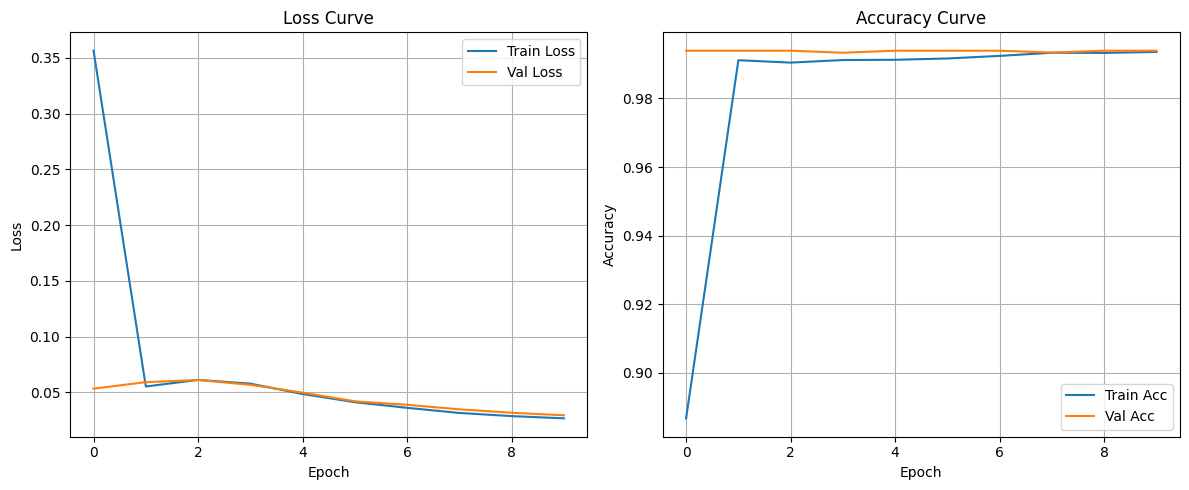

In [72]:
# Training setup
batch_size = 128
learning_rate = 0.01
num_epochs = 10
model = ProcedureMLP(input_dim=X_tensor.shape[1], output_dim=y_tensor.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), learning_rate)

# Training loop
train_loader = DataLoader(train_set, batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size)
test_loader = DataLoader(test_set, batch_size)
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    # Train
    model.train()
    total_loss, correct, total = 0, 0, 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (pred >= 0.5).eq(yb).sum().item()
        total += torch.numel(yb)
    train_losses.append(total_loss / len(train_loader))
    train_accs.append(correct / total)

    # Validate
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            val_loss += criterion(pred, yb).item()
            val_correct += (pred >= 0.5).eq(yb).sum().item()
            val_total += torch.numel(yb)
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | "
          f"Train Acc: {train_accs[-1]:.4f} | Val Acc: {val_accs[-1]:.4f}")

# Plot curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Epoch 1 | Train Loss: 0.6932 | Val Loss: 0.6916 | Train Acc: 0.4994 | Val Acc: 0.5228
Epoch 2 | Train Loss: 0.6897 | Val Loss: 0.6875 | Train Acc: 0.5408 | Val Acc: 0.5692
Epoch 3 | Train Loss: 0.6845 | Val Loss: 0.6808 | Train Acc: 0.5946 | Val Acc: 0.6419
Epoch 4 | Train Loss: 0.6757 | Val Loss: 0.6689 | Train Acc: 0.6694 | Val Acc: 0.7340
Epoch 5 | Train Loss: 0.6599 | Val Loss: 0.6477 | Train Acc: 0.7603 | Val Acc: 0.8345
Epoch 6 | Train Loss: 0.6331 | Val Loss: 0.6122 | Train Acc: 0.8487 | Val Acc: 0.9205
Epoch 7 | Train Loss: 0.5897 | Val Loss: 0.5572 | Train Acc: 0.9170 | Val Acc: 0.9697
Epoch 8 | Train Loss: 0.5248 | Val Loss: 0.4814 | Train Acc: 0.9599 | Val Acc: 0.9880
Epoch 9 | Train Loss: 0.4437 | Val Loss: 0.3904 | Train Acc: 0.9812 | Val Acc: 0.9913
Epoch 10 | Train Loss: 0.3528 | Val Loss: 0.2982 | Train Acc: 0.9898 | Val Acc: 0.9937
Epoch 11 | Train Loss: 0.2649 | Val Loss: 0.2191 | Train Acc: 0.9928 | Val Acc: 0.9939
Epoch 12 | Train Loss: 0.1927 | Val Loss: 0.1605 | T

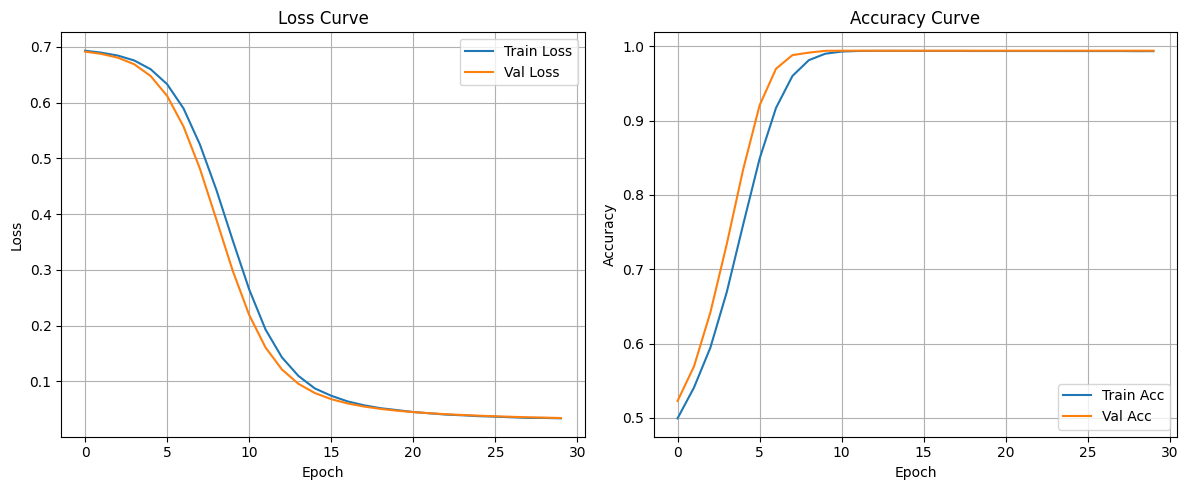

In [73]:
# Training setup
batch_size = 64
learning_rate = 0.0001
num_epochs = 30
model = ProcedureMLP(input_dim=X_tensor.shape[1], output_dim=y_tensor.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), learning_rate)

# Training loop
train_loader = DataLoader(train_set, batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size)
test_loader = DataLoader(test_set, batch_size)
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    # Train
    model.train()
    total_loss, correct, total = 0, 0, 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (pred >= 0.5).eq(yb).sum().item()
        total += torch.numel(yb)
    train_losses.append(total_loss / len(train_loader))
    train_accs.append(correct / total)

    # Validate
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            val_loss += criterion(pred, yb).item()
            val_correct += (pred >= 0.5).eq(yb).sum().item()
            val_total += torch.numel(yb)
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | "
          f"Train Acc: {train_accs[-1]:.4f} | Val Acc: {val_accs[-1]:.4f}")

# Plot curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [74]:
# Save model
torch.save({
    'model_state': model.state_dict(),
    'input_dim': X_tensor.shape[1],
    'output_dim': y_tensor.shape[1],
    'hidden_dims': [256, 128],
    'dropout': 0.3,
    'batch_size': 64,
    'learning_rate': 1e-4,
    'epoch': 30
}, "model1_full.pth")

### Model evaluation (test data)

In [75]:
# Load full checkpoint
checkpoint = torch.load("model1_full.pth")

# Rebuild the model with saved hyperparameters
model1 = ProcedureMLP(
    input_dim=checkpoint['input_dim'],
    output_dim=checkpoint['output_dim'],
    hidden_dims=checkpoint['hidden_dims'],
    dropout=checkpoint['dropout']
)

model1.load_state_dict(checkpoint['model_state'])
model1.eval()


C:\Users\frank\AppData\Local\Temp\ipykernel_32452\2846798956.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("model1_full.pth")


ProcedureMLP(
  (network): Sequential(
    (0): Linear(in_features=582, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=582, bias=True)
  )
)

In [76]:
def evaluate_model1(model, dataloader, k=5):
    model1.eval()
    total_correct = 0
    total_labels = 0
    total_precision = 0
    total_recall = 0
    n_samples = 0

    with torch.no_grad():
        for xb, yb in dataloader:
            pred = model(xb)

            # Binary thresholding for accuracy
            pred_labels = (pred >= 0.5).float()
            total_correct += (pred_labels == yb).sum().item()
            total_labels += torch.numel(yb)

            # Top-K prediction evaluation
            topk = torch.topk(pred, k=k, dim=1).indices
            for i in range(pred.size(0)):
                true_indices = torch.nonzero(yb[i]).flatten().tolist()
                pred_indices = topk[i].tolist()
                
                if not true_indices:
                    continue
                
                true_set = set(true_indices)
                pred_set = set(pred_indices)

                total_precision += len(pred_set & true_set) / k
                total_recall += len(pred_set & true_set) / len(true_set)
                n_samples += 1

    accuracy = total_correct / total_labels
    precision_k = total_precision / n_samples if n_samples > 0 else 0
    recall_k = total_recall / n_samples if n_samples > 0 else 0

    print(f"Evaluation on Test Set:")
    print(f"Binary Accuracy     : {accuracy:.4f}")
    print(f"Precision@{k}       : {precision_k:.4f}")
    print(f"Recall@{k}          : {recall_k:.4f}")


evaluate_model1(model1, test_loader, k=5)


Evaluation on Test Set:
Binary Accuracy     : 0.9937
Precision@5       : 0.2579
Recall@5          : 0.3242


### Demo

Supervised models like MLP is a great baseline because it's to train and can analyze which features influence predictions.  
But Not Ideal Long-Term because:  
- They don't learn from implicit signals (e.g., "what users didn't do").
- No feedback loop or real-time learning.
- Don’t capture sequence dependencies or latent patterns as well as:

Supervised MLP is a strong cold-start baseline, but not optimal for long-term or dynamic recommendations.

In [77]:
# Pick a patient index
patient_idx = 30
x_sample = torch.tensor(X.iloc[patient_idx].values, dtype=torch.float32).unsqueeze(0)  # [1, input_dim]
y_true = y.iloc[patient_idx]  # actual future procedures
procedure_names = X.columns  # one-hot columns

# Get model prediction
model1.eval()
with torch.no_grad():
    y_pred = model1(x_sample).squeeze()  # [output_dim]

# Top-K predicted procedures
k = 5
topk_indices = torch.topk(y_pred, k=k).indices.tolist()
topk_scores = torch.topk(y_pred, k=k).values.tolist()
topk_procedures = [procedure_names[i] for i in topk_indices]

# True procedures
true_indices = set(torch.nonzero(torch.tensor(y_true.values)).squeeze().flatten().tolist())
true_procedures = [procedure_names[i] for i in true_indices]

# Display
print(f"Patient Index: {patient_idx}")
print(f"\nTrue Procedures at Age 36:")
print(true_procedures)

print(f"\nTop-{k} Predicted Procedures:")
for i, proc in enumerate(topk_procedures):
    correct = "TRUE" if topk_indices[i] in true_indices else "FALSE"
    print(f"{correct} {proc} (score: {topk_scores[i]:.4f})")


Patient Index: 30

True Procedures at Age 36:
['procedure_code_y_11113', 'procedure_code_y_11114', 'procedure_code_y_1203', 'procedure_code_y_1204', 'procedure_code_y_43414', 'procedure_code_y_12101']

Top-5 Predicted Procedures:
TRUE procedure_code_y_11113 (score: 0.3378)
TRUE procedure_code_y_12101 (score: 0.3054)
TRUE procedure_code_y_1204 (score: 0.2744)
FALSE procedure_code_y_2144 (score: 0.2015)
FALSE procedure_code_y_11107 (score: 0.1890)


## LSTM

## Collaberative Filter

Collaborative Filtering makes predictions by learning from the behavior of similar users or similar items, without needing feature-level information.
- User: Patients (patient_id)
- Item: Procedure codes (procedure_code_y)
- Rating: Binary treatment indicator (0/1)
- Interaction Matrix: Patients * Procedures

In [81]:
X

,procedure_code_y_1011,procedure_code_y_1101,procedure_code_y_1102,procedure_code_y_1103,procedure_code_y_1104,procedure_code_y_1105,procedure_code_y_1110,procedure_code_y_1120,procedure_code_y_1130,procedure_code_y_1200,...,procedure_code_y_97112,procedure_code_y_97113,procedure_code_y_97119,procedure_code_y_97121,procedure_code_y_97122,procedure_code_y_97123,procedure_code_y_97133,procedure_code_y_99111,procedure_code_y_99333,procedure_code_y_99555
patient_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13016,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13017,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13084,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
y

,procedure_code_y_1011,procedure_code_y_1101,procedure_code_y_1102,procedure_code_y_1103,procedure_code_y_1104,procedure_code_y_1105,procedure_code_y_1110,procedure_code_y_1120,procedure_code_y_1130,procedure_code_y_1200,...,procedure_code_y_97112,procedure_code_y_97113,procedure_code_y_97119,procedure_code_y_97121,procedure_code_y_97122,procedure_code_y_97123,procedure_code_y_97133,procedure_code_y_99111,procedure_code_y_99333,procedure_code_y_99555
patient_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13016,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
13017,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13084,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
import pandas as pd
import torch

# X: binary matrix [n_patients, n_procedures] from your age 31–35 input
X_binary = (X > 0).astype(int)
user_to_idx = {pid: i for i, pid in enumerate(X_binary.index)}
item_to_idx = {col: i for i, col in enumerate(X_binary.columns)}
interactions = []

# Convert multi-hot rows to (user_idx, item_idx, label=1) triplets
for user_id, row in X_binary.iterrows():
    u_idx = user_to_idx[user_id]
    for item in row[row == 1].index:
        i_idx = item_to_idx[item]
        interactions.append((u_idx, i_idx, 1))
inter_df = pd.DataFrame(interactions, columns=['user', 'item', 'label'])


In [5]:
from torch.utils.data import Dataset, DataLoader

# Build Dataset and DataLoader
class CFDataset(Dataset):
    def __init__(self, df):
        self.users = torch.tensor(df['user'].values, dtype=torch.long)
        self.items = torch.tensor(df['item'].values, dtype=torch.long)
        self.labels = torch.tensor(df['label'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

In [8]:
dataset = CFDataset(inter_df)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

class CFDModel(nn.Module):
    def __init__(self, num_users, num_items, emb_dim=64):
        super().__init__()
        self.user_embed = nn.Embedding(num_users, emb_dim)
        self.item_embed = nn.Embedding(num_items, emb_dim)
    def forward(self, user_idx, item_idx):
        u = self.user_embed(user_idx)
        i = self.item_embed(item_idx)
        return torch.sigmoid((u * i).sum(dim=1))


# Training
num_users = len(user_to_idx)
num_items = len(item_to_idx)
model = CFDModel(num_users, num_items, emb_dim=64)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()
epoch = 30

for epoch in range(epoch):
    model.train()
    total_loss = 0
    for user_idx, item_idx, label in dataloader:
        pred = model(user_idx, item_idx)
        loss = loss_fn(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss / len(dataloader):.4f}")

Epoch 1 Loss: 3.1892
Epoch 2 Loss: 3.0676
Epoch 3 Loss: 2.9331
Epoch 4 Loss: 2.8330
Epoch 5 Loss: 2.7186
Epoch 6 Loss: 2.6036
Epoch 7 Loss: 2.5036
Epoch 8 Loss: 2.4005
Epoch 9 Loss: 2.3054
Epoch 10 Loss: 2.2018
Epoch 11 Loss: 2.1191
Epoch 12 Loss: 2.0222
Epoch 13 Loss: 1.9374
Epoch 14 Loss: 1.8557
Epoch 15 Loss: 1.7711
Epoch 16 Loss: 1.6975
Epoch 17 Loss: 1.6109
Epoch 18 Loss: 1.5416
Epoch 19 Loss: 1.4645
Epoch 20 Loss: 1.3963
Epoch 21 Loss: 1.3343
Epoch 22 Loss: 1.2697
Epoch 23 Loss: 1.2123
Epoch 24 Loss: 1.1434
Epoch 25 Loss: 1.0967
Epoch 26 Loss: 1.0378
Epoch 27 Loss: 0.9817
Epoch 28 Loss: 0.9327
Epoch 29 Loss: 0.8843
Epoch 30 Loss: 0.8375
